In [1]:
from modelzipper.tutils import *
import matplotlib.pylab as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np


TASK_LABELS = {'qa1': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa2': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa3': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa4': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa5': ['Bill', 'Fred', 'Jeff', 'Mary', 'apple', 'football', 'milk'], 
 'qa6': ['no', 'yes'], 
 'qa7': ['none', 'one', 'three', 'two'], 
 'qa8': ['apple', 'football', 'milk', 'nothing'], 
 'qa9': ['no', 'yes'], 
 'qa10': ['maybe', 'no', 'yes'],
 'qa11': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa12': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa13': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa14': ['bedroom', 'cinema', 'kitchen', 'office', 'park', 'school'], 
 'qa15': ['cat', 'mouse', 'sheep', 'wolf'], 
 'qa16': ['gray', 'green', 'white', 'yellow'], 
 'qa17': ['no', 'yes'], 
 'qa18': ['no', 'yes'], 
 'qa19': ['e,e', 'e,n', 'e,s', 'n,e', 'n,n', 'n,w', 's,e', 's,s', 's,w', 'w,n', 'w,s', 'w,w'], 
 'qa20': ['bedroom', 'bored', 'garden', 'hungry', 'kitchen', 'thirsty', 'tired']
}


def preprocess_output(output):
    output = output.lower()
    # take only the first sentence from output
    output = output.split('.')[0]
    # filter responses when model tries to generate examples
    output = output.split('<context>')[0]
    output = output.split('<example>')[0]
    output = output.split('Question')[0]
    return output


def compare_answers(target, output, task_labels, question):
    output = preprocess_output(output)
    target = target.lower()
    
    # extract labels that were mentioned in the model output
    labels_in_output = {label for label in task_labels if label in output}
    labels_in_question = {label for label in task_labels if label in question}  # should exclude the labels in the question
    labels_in_output = labels_in_output - labels_in_question

    # check if the target is the only prediction
    if ',' in target and len(target) > 3: 
        # if target contains multiple subtargets in qa8
        subtargets = target.split(',')
        num_subtargets = len(subtargets)
        if all([t in labels_in_output for t in subtargets]) and len(labels_in_output) == num_subtargets:
            return True
    else:
        if target in labels_in_output and len(labels_in_output) == 1:
            return True

    return False


def eval_fn(pred_path, save_path, model_name=""):
    tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5', 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
    lengths = ['4k', '8k', '16k', '32k', '64k', '128k']
    content = auto_read_data(pred_path)

    all_results = dict([(task, dict([(length, []) for length in lengths])) for task in tasks])

    # 填充 DataFrame
    for item in content:
        task, ctx_length = item['task'], item['ctx_length']
        pred, golden, question = item['pred'][0], item['golden'], item['question']
        all_results[task][ctx_length].append((golden, pred, TASK_LABELS[task], question))

    for task, item in all_results.items():
        for length, content in item.items():
            acc = np.array([compare_answers(*item) for item in content]).mean()
            all_results[task][length] = acc
    
    # 转换字典为DataFrame
    df = pd.DataFrame(all_results).T
    df.index.name = 'Task'

    # 重排序：任务按照qa1到qa10排序，长度按4k, 8k, 16k, 32k, 64k, 128k排序
    # df = df.sort_index(axis=0, ascending=True)  # 排序任务名
    # df = df[sorted(df.columns, key=lambda x: int(x.replace('k', '')))]  # 排序长度

    # 绘制热力图
    matplotlib.rc('font', size=14)  # 设置字体大小
    cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)  # 自定义颜色
    figsize = (5, 3.5)
    fig, ax = plt.subplots(1, 1, figsize=figsize)  # 创建图形

    # 使用seaborn绘制热力图
    sns.heatmap(df, cmap=cmap, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, ax=ax)

    # 设置标题和标签
    ax.set_title(model_name)
    ax.set_xlabel('Context size')
    ax.set_ylabel('Tasks')

    # 调整边距以删除多余的白色边框
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    plt.savefig(save_path, bbox_inches='tight', dpi=300)

    return df

/mnt/petrelfs/tangzecheng/anaconda3/envs/zecheng_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModelZipper is ready for launch🚀 | Current Version🦄 >>> 0.2.7 <<< | AOE Time🕒 2024-11-30 22:27:40


2024-11-30 18:33:43.429 | INFO     | modelzipper.tutils:auto_mkdir:294 - /mnt/petrelfs/tangzecheng/MyRLHF/evaluation/babilong/llama-3_1-8B-Instruct/preliminary already exists!
2024-11-30 18:33:43.431 | INFO     | modelzipper.tutils:auto_read_data:182 - begin to read data from /mnt/petrelfs/tangzecheng/local_data/inference_results/llama-3_1-8B-Instruct/babilong/reasoning/preds_babilong.jsonl | file size: 1.76 MB | file type: jsonl


        4k    8k   16k   32k   64k  128k
Task                                    
qa1   0.88  0.85  0.70  0.50  0.37  0.02
qa2   0.34  0.39  0.36  0.27  0.26  0.01
qa3   0.22  0.22  0.23  0.22  0.20  0.08
qa4   0.25  0.20  0.23  0.26  0.23  0.17
qa5   0.09  0.03  0.03  0.04  0.03  0.02
qa6   0.50  0.54  0.52  0.31  0.18  0.15
qa7   0.26  0.08  0.04  0.00  0.01  0.01
qa8   0.39  0.30  0.24  0.09  0.08  0.02
qa9   0.67  0.63  0.65  0.35  0.35  0.30
qa10  0.39  0.47  0.38  0.22  0.20  0.13


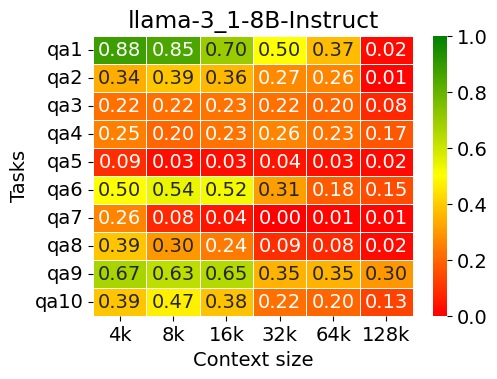

In [2]:
model_name = 'llama-3_1-8B-Instruct'
# pred_path = '/data/zecheng/acl2025/MyRLHF/evaluation/babilong/llama-3_1-8B-Instruct/babilong/reasoning/preds_babilong.jsonl'
pred_path = '/mnt/petrelfs/tangzecheng/local_data/inference_results/llama-3_1-8B-Instruct/babilong/reasoning/preds_babilong.jsonl'
save_dir = '/mnt/petrelfs/tangzecheng/MyRLHF/evaluation/babilong/llama-3_1-8B-Instruct/preliminary'
# save_dir = '/data/zecheng/acl2025/MyRLHF/evaluation/babilong/llama-3_1-8B-Instruct'
auto_mkdir(save_dir)
save_path = os.path.join(save_dir, "heatmap_result.png")
 
res = eval_fn(pred_path, save_path, model_name)
print(res)